# Advent of code 2023

Solutions are my own, if any external source including hints have been used it shall be mentioned and linked. 

#### External help

### Part 2
    - interval arithmetics, I'm none the wiser!!! https://en.wikipedia.org/wiki/Interval_arithmetic
    - I've checked this solution https://www.youtube.com/watch?v=iqTopXV13LE

visual below we need to keep track of all the overlaps of all of the intervals

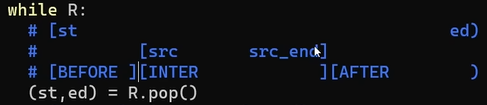





## Part 1

----- Day 5: Almanac ---

The almanac (your puzzle input) lists all of the seeds that need to be planted. It also lists what type of soil to use with each kind of seed, what type of fertilizer to use with each kind of soil, what type of water to use with each kind of fertilizer, and so on. Every type of seed, soil, fertilizer and so on is identified with a number, but numbers are reused by each category - that is, soil 123 and fertilizer 123 aren't necessarily related to each other.

For example:
```
seeds: 79 14 55 13

seed-to-soil map:
50 98 2
52 50 48

soil-to-fertilizer map:
0 15 37
37 52 2
39 0 15

fertilizer-to-water map:
49 53 8
0 11 42
42 0 7
57 7 4

water-to-light map:
88 18 7
18 25 70

light-to-temperature map:
45 77 23
81 45 19
68 64 13

temperature-to-humidity map:
0 69 1
1 0 69

humidity-to-location map:
60 56 37
56 93 4
```
The almanac starts by listing which seeds need to be planted: seeds 79, 14, 55, and 13.

The rest of the almanac contains a list of maps which describe how to convert numbers from a source category into numbers in a destination category. That is, the section that starts with seed-to-soil map: describes how to convert a seed number (the source) to a soil number (the destination). This lets the gardener and his team know which soil to use with which seeds, which water to use with which fertilizer, and so on.

Rather than list every source number and its corresponding destination number one by one, the maps describe entire ranges of numbers that can be converted. Each line within a map contains three numbers: the destination range start, the source range start, and the range length.

Consider again the example seed-to-soil map:
```
50 98 2
52 50 48
```
The first line has a destination range start of 50, a source range start of 98, and a range length of 2. This line means that the source range starts at 98 and contains two values: 98 and 99. The destination range is the same length, but it starts at 50, so its two values are 50 and 51. With this information, you know that seed number 98 corresponds to soil number 50 and that seed number 99 corresponds to soil number 51.

The second line means that the source range starts at 50 and contains 48 values: 50, 51, ..., 96, 97. This corresponds to a destination range starting at 52 and also containing 48 values: 52, 53, ..., 98, 99. So, seed number 53 corresponds to soil number 55.

Any source numbers that aren't mapped correspond to the same destination number. So, seed number 10 corresponds to soil number 10.



So, the entire list of seed numbers and their corresponding soil numbers looks like this:
```
seed  soil
0     0
1     1
...   ...
48    48
49    49
50    52
51    53
...   ...
96    98
97    99
98    50
99    51
```
With this map, you can look up the soil number required for each initial seed number:

    Seed number 79 corresponds to soil number 81.
    Seed number 14 corresponds to soil number 14.
    Seed number 55 corresponds to soil number 57.
    Seed number 13 corresponds to soil number 13.

The gardener and his team want to get started as soon as possible, so they'd like to know the closest location that needs a seed. Using these maps, find the lowest location number that corresponds to any of the initial seeds. To do this, you'll need to convert each seed number through other categories until you can find its corresponding location number. In this example, the corresponding types are:

    Seed 79, soil 81, fertilizer 81, water 81, light 74, temperature 78, humidity 78, location 82.
    Seed 14, soil 14, fertilizer 53, water 49, light 42, temperature 42, humidity 43, location 43.
    Seed 55, soil 57, fertilizer 57, water 53, light 46, temperature 82, humidity 82, location 86.
    Seed 13, soil 13, fertilizer 52, water 41, light 34, temperature 34, humidity 35, location 35.

So, the lowest location number in this example is 35.

What is the lowest location number that corresponds to any of the initial seed numbers?

In [14]:
from dataclasses import dataclass
from tqdm import tqdm

TEST = """seeds: 79 14 55 13

seed-to-soil map:
50 98 2
52 50 48

soil-to-fertilizer map:
0 15 37
37 52 2
39 0 15

fertilizer-to-water map:
49 53 8
0 11 42
42 0 7
57 7 4

water-to-light map:
88 18 7
18 25 70

light-to-temperature map:
45 77 23
81 45 19
68 64 13

temperature-to-humidity map:
0 69 1
1 0 69

humidity-to-location map:
60 56 37
56 93 4"""


PHASES =  {'seed':0,
          'seed-to-soil':1,
          'soil-to-fertilizer':2,
          'fertilizer-to-water':3,
          'water-to-light':4,
          'light-to-temperature':5,
          'temperature-to-humidity':6,
          'humidity-to-location':7
          }

@dataclass
class Map:
    name: str
    source: int
    dest: int
    range_: int

    def __post_init__(self):
        self.get_phase()

    def get_phase(self):
        phases = {'seed':0,
          'seed-to-soil':1,
          'soil-to-fertilizer':2,
          'fertilizer-to-water':3,
          'water-to-light':4,
          'light-to-temperature':5,
          'temperature-to-humidity':6,
          'humidity-to-location':7
          }
        self.phase = phases[self.name]


def parse_puzzle(puzzle:str, part1:bool=True)->str:
    puzzle_lines = puzzle.split("\n\n")
    mappers = []
    for row in puzzle_lines:
        if part1: # part 1 add seeds parsing
            if "seeds" in row: # part 1 parse seeds
                dest = (int(i) for i in row.split(":")[-1].split())
                for seed in dest:
                    mappers.append(Map(name="seed", 
                                source=None, 
                                dest=seed,
                                range_=None))
            
        
            
        name, rest = row.split()[0], row.split()[1:]
        for rest in row.split("\n")[1:]:
            dest, source, range_ = rest.split()
            mappers.append(Map(name=name,
                                source=int(source),
                                dest=int(dest),
                                range_=int(range_))
            )
    return mappers
                
ALMANAC = dict[int, list[dict[str, int|range]]]

def create_almanac(maps:list[Map])->ALMANAC:

    almanac = dict()
    prior_phase, post_phase = 0 , 1
    for phase in range(0, 7): 
        if not almanac:
            # starting phase prior get dest values from seed maps
            prior_dest_values = set(m.dest for m in maps
                                    if m.phase == prior_phase)
        else:
            # starting phase prior get dest values from almanac
            prior_dest_values = set(
                        data['post_src_value']
                        for data in almanac[prior_phase] 
                        )
        # isolate the maps of interest in the posterior phase
        post_maps = [m for m in maps
                    if m.phase == post_phase]

        # prior dest range is found as the source of the post phase
        prior_dest_ranges = [(m.source, m.source + m.range_)
                        for m in post_maps]

        # post dest range is used to calc the post src value
        posterior_dest_ranges = [(m.dest, m.dest+m.range_)
                        for m in post_maps]

        matches = list()
        for p_dest_value in prior_dest_values:
            for i, (low, high) in enumerate(prior_dest_ranges):
                if low <= p_dest_value < high:
                    post_low, post_high = posterior_dest_ranges[i]
                    post_src_value = (post_low - low) + p_dest_value
                    matches.append({'prior_dest_value':p_dest_value, 
                                    'prior_dest_range': range(low, high),
                                    'post_src_range': range(post_low, post_high),
                                    'post_src_value':post_src_value 
                                    })
                    
        captured_prior_dest_values = set(
            m['prior_dest_value']
            for m in matches
        )
        # compared missed in matched vs prior dest
        misssed_prior_dest_values = prior_dest_values - captured_prior_dest_values

        # assign same 
        for val in misssed_prior_dest_values:
            matches.append(
            {'prior_dest_value':val, 
            'prior_dest_range':None,
            'post_src_range': None,
            'post_src_value':val }
            )

        almanac[post_phase] = matches
        prior_phase, post_phase = post_phase, post_phase + 1
    return almanac


def get_seed_source_from_range(puzzle:str)->int:
    """after almanac creation extract location value given the seed passed in
    """
    # return almanac[7][0]['post_src_value']


def part1(puzzle:str)->int:
    """find min locations"""
    maps = parse_puzzle(puzzle=puzzle, part1=True)
    return min(
        data['post_src_value']
        for phase, values in create_almanac(maps=maps).items()
        for data in values
        if phase == 7
    )


def parse_ranges(seeds:str, maps:list[Map]):
    """yields a new map based on seed range
    """
    ranges = seeds.split()
    for i in range(0, len(ranges), 2):
        start = int(ranges[i])
        end = start + int(ranges[i+1])

        # Yield numbers within the range
        for num in range(start, end + 1):
            seed =  Map(name="seed",
                source=None, 
                dest=num,
                range_=None)
            new_maps = [seed] + maps.copy()
            yield new_maps

def parse_seed_ranges(puzzle:str):
    seeds = puzzle.split("\n")[0].split(": ")[-1]
    ranges = seeds.split()
    seeds = list()
    for i in range(0, len(ranges), 2):
        start = int(ranges[i])
        end = start + int(ranges[i+1])
        seeds.append((start, end))
    return seeds


def part2(puzzle:str)->int:
    """find min locations part 2"""
    maps = parse_puzzle(puzzle=puzzle, part1=False)
    seeds = parse_seed_ranges(puzzle)
    
    for phase in PHASES:
        phase_maps = [m for m in maps if m.name == phase]
        new = list()
        while seeds:
            seed_start, seed_end = seeds.pop()
            # print("seed is",seed_start, seed_end)
            for map_ in phase_maps:
                # print("mapping is",map_.dest,map_.source,map_.range_)
                overlap_start = max(seed_start, map_.source) # start of the range is the start of the right most range
                overlap_end = min(seed_end, map_.source + map_.range_) # end of the range will be the min of the ending value
                # print("os", overlap_start)
                # print("oe", overlap_end)
                if overlap_start < overlap_end: # non empty range
                        # define our range 
                    new.append((overlap_start - map_.source + map_.dest, 
                                overlap_end - map_.source + map_.dest))
                    # cases where start and end intervals are missed
                    if overlap_start > seed_start: 
                        seeds.append((seed_start, overlap_start))
                    if seed_end > overlap_end:
                        seeds.append((overlap_end, seed_end))
                    break
            else: # if none of the ranges match
                new.append((seed_start, seed_end)) # no mappings keep range
        seeds = new
    return min(seeds)[0]

min_location_test = part1(puzzle=TEST)
min_location_test_p2 = part2(puzzle=TEST)

assert min_location_test == 35
assert min_location_test_p2 == 46




## Part 2

## Solutions

In [16]:
with open("puzzle_input/day05.txt") as file:
    puzzle = file.read()

print("part1", part1(puzzle=puzzle))
print("part2", part2(puzzle=puzzle))
# print("part2", sum(part2(puzzle=puzzle, numbers=numbers)))

part1 424490994
part2 15290096
